## Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Colaboration
Refered to https://www.kaggle.com/code/wti200/analysing-interactions-with-shap issued by ***@WTI200***<br>
and https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense/notebook issued by ***@AMBROSM***

## Blue print

1. Check data shape and type.
2. Convert chracteristic values to numbers.
3. Split training dataset to *ourtrain* and *ourtest*.
4. Dimensionality reduction.
5. Try various models(logistic regression, decision tree, random forest, SVM, KNN, Naive Bayes).
6. Apply to the test dataset.

## Import Packages

In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Show all columns
pd.set_option("display.max_columns", None)

## 1. Load Data

In [2]:
# Load dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape, test.shape

((900000, 33), (700000, 32))

In [3]:
# Check data types and missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-null  float64
 21  f_20    90

In [4]:
# Seperate 'id'
train_id = train['id']
test_id = test['id']

# Drop 'id'
train= train.drop(columns=['id'])
test = test.drop(columns=['id'])

train.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


In [5]:
X = train.drop(columns=['target'])
Y = train['target']

X.shape, Y.shape

((900000, 31), (900000,))

### - Split into Train set and Validation set

In [6]:
from sklearn.model_selection import train_test_split

Xtr, Xva, Ytr, Yva = train_test_split(X, Y, test_size=0.33, random_state=0)

# Reset indices
Xtr.reset_index(drop=True, inplace=True) 
Xva.reset_index(drop=True, inplace=True)     
Ytr.reset_index(drop=True, inplace=True)
Yva.reset_index(drop=True, inplace=True)

# Update (We don't want to 'peek' the validation set!)
train = pd.concat([Xtr, Ytr], axis=1)

## 2. Data Investigation

### 1) Numeric features

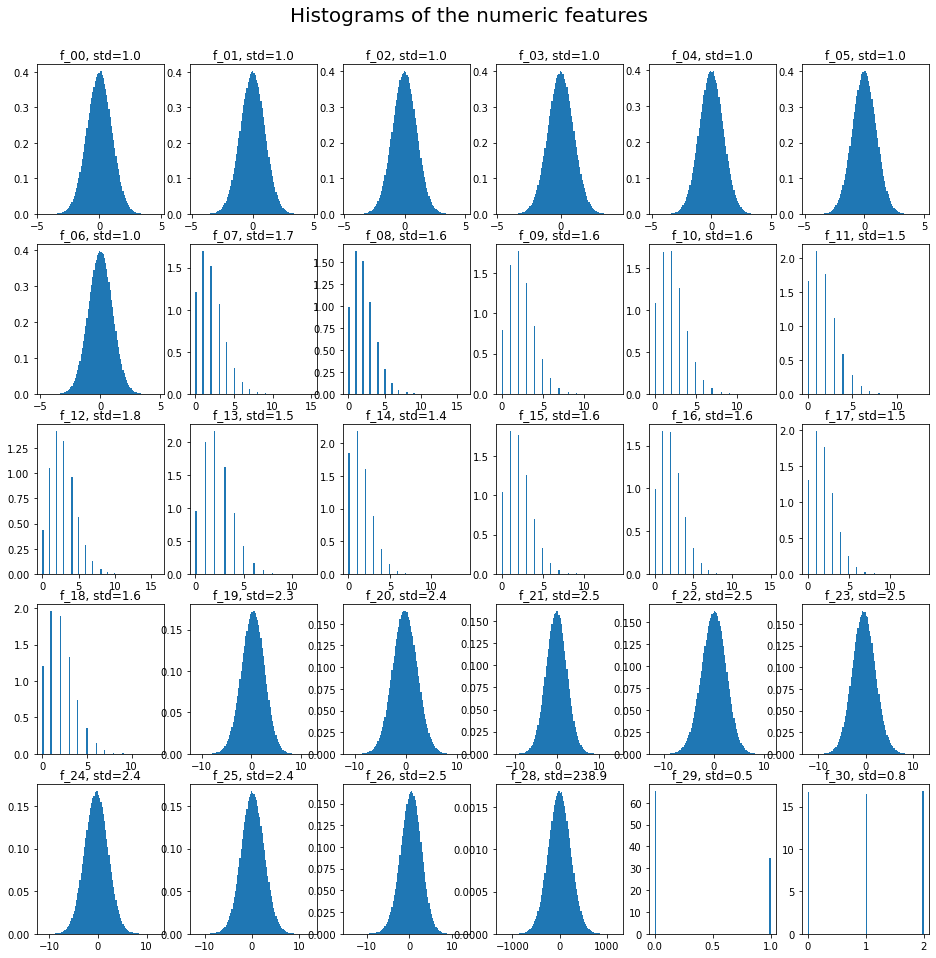

In [7]:
num_features = [c for c in X.columns if (X[c].dtype == 'float64') | (X[c].dtype == 'int64')]

# Check histograms
fig, axs = plt.subplots(5, 6, figsize=(16, 16))
for f, ax in zip(num_features, axs.ravel()):    # paring each feature for each ax
    ax.hist(X[f], density=True, bins=100)
    ax.set_title(f'{f}, std={train[f].std():.1f}')
plt.suptitle('Histograms of the numeric features', y=0.93, fontsize=20)
plt.show()

$\Rightarrow$ It seems like there is no big outlier, so normalization will work fine.

<AxesSubplot:>

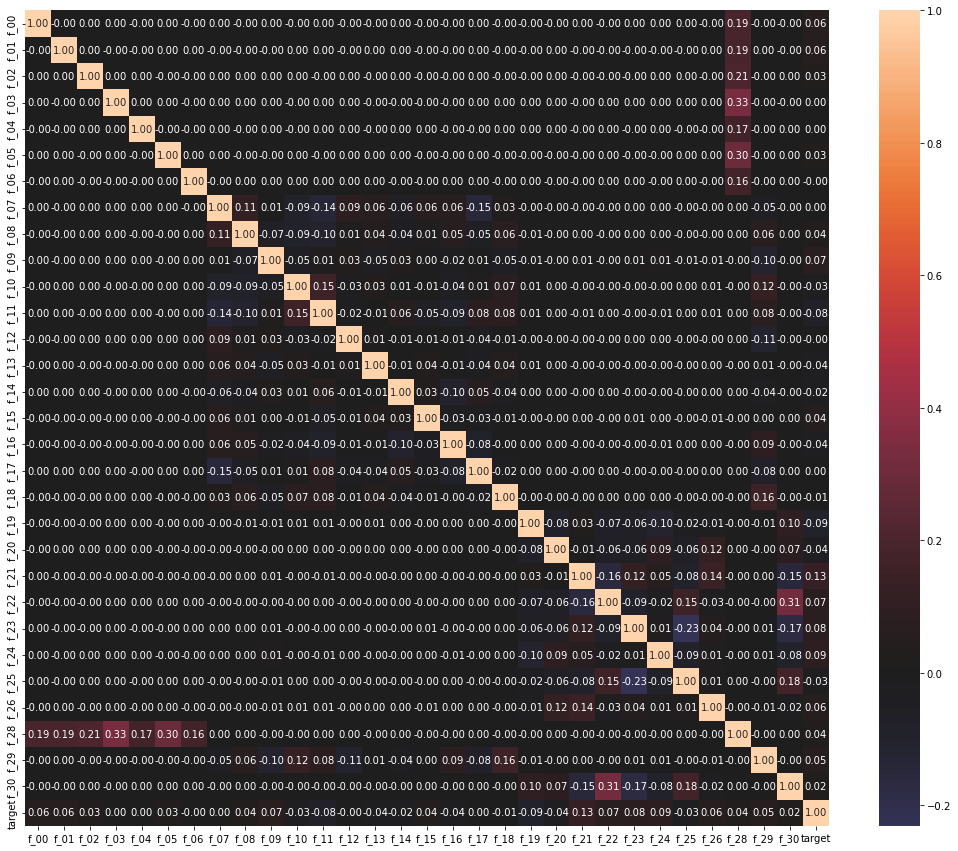

In [8]:
# Check correlations
plt.figure(figsize=(18, 15))
sns.heatmap(train.corr(), center=0, annot=True, fmt='.2f')

$\Rightarrow$ `f_00`-`f_06` are correlated to `f_28`, and there are some features correalted to `f_29` and `f_30`, but nothing signaficantly strong.The hightest correlation is **0.33** which is between `f_03` and `f_28`.<br>

$\Rightarrow$ `f_03`, `f_04`, `f_06`, `f_07`, `f_12`, and `f_17` are **not** correlated with the target. 

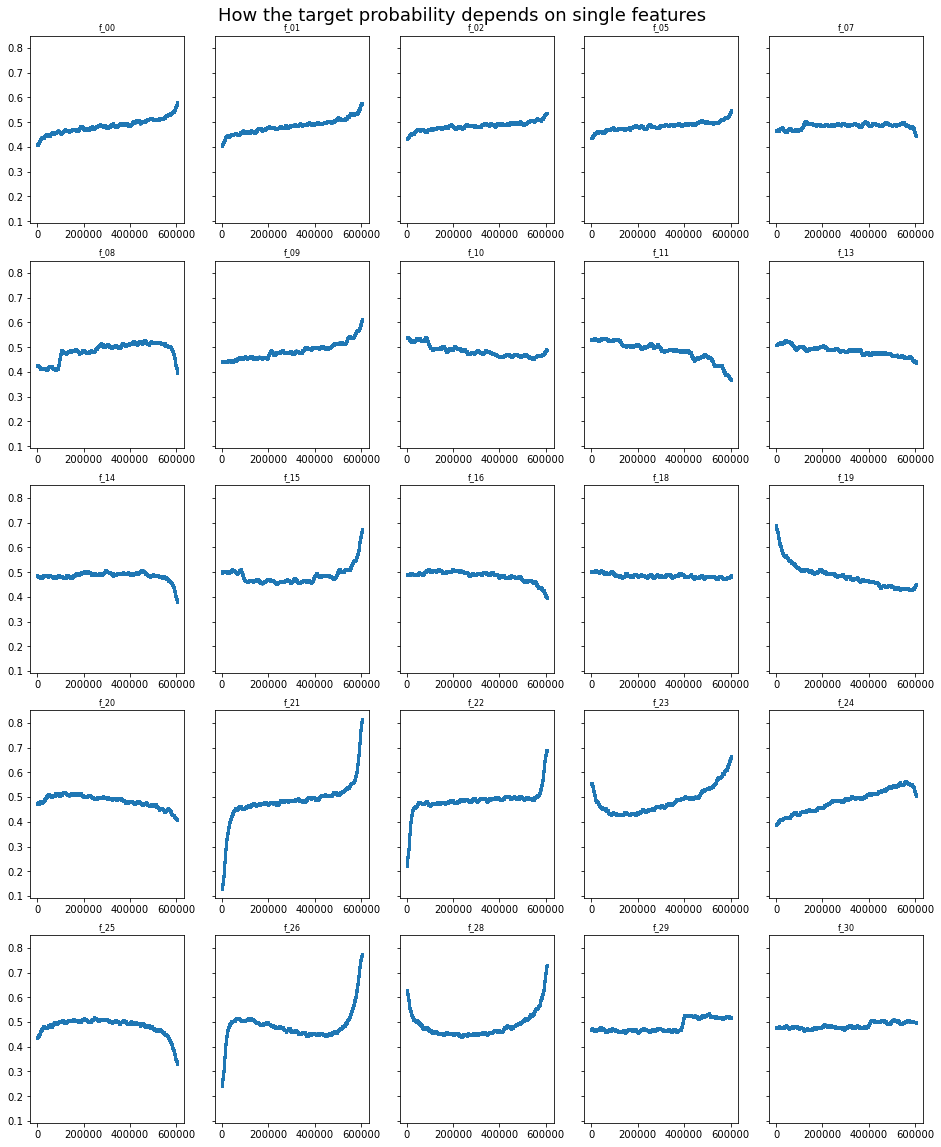

In [9]:
not_cor = ['f_03', 'f_04', 'f_06', 'f_17', 'f_12', 'f_27']
cor_num_features = X.drop(columns=not_cor).columns

# Plot dependence between the target and its correlated numeric features
def plot_single_features(df, features, ncols=5, title='title'):
                 
    nrows = (len(features) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows*4), sharey=True)

    for f, ax in zip(features, axs.ravel()):
        # dataframe with single feature and target
        temp = pd.concat([df[f], df['target']], axis=1)
        temp = temp.sort_values(f)  # sort in ascending order
        temp.reset_index(inplace=True)

        # Compute rolling mean
        rolling_mean = temp['target'].rolling(window=15000, min_periods=1, center=True).mean()

        # Plot
        ax.scatter(temp.index, rolling_mean, s=2)
        ax.set_title(f, fontsize=8)

    plt.suptitle(title, y=0.90, fontsize=18)
    plt.show()

plot_single_features(train, cor_num_features, title='How the target probability depends on single features')

$\Rightarrow$ Because of many nonlinear relationships, linear classification will not be effective.

### 2) Object Features

In [10]:
# Check unique value counts
train['f_27'].value_counts()

BBBBBBCJBC    9
ACBBAABABC    8
BCBBBBCLBC    8
BCBCAABKBB    8
BBBBBABLBD    8
             ..
AABBAACNCC    1
ACBBAACMDC    1
ABABAAHFBA    1
AABBBAAOFB    1
BBBBAAAGBC    1
Name: f_27, Length: 524944, dtype: int64

$\Rightarrow$ We cannot be certain that these string values are all the possible values. There might be a new combination of letter in validation/test set. We should split each letter.

In [11]:
# Check length of the strings
max(train['f_27'].str.len().values), min(train['f_27'].str.len().values)

(10, 10)

$\Rightarrow$ All codes consist of 10 letters.

In [12]:
# Return 'n'th character
def nth_char(column, n):
    count = 1
    nth = []
    for characters in column:
        for char in characters:
            if count == n:
                nth.append(char)
                count = 1
                break
            else:
                count += 1
    return nth

# Split into letters
def split_to_letter(df, col):
    store = []

    # Split the letters
    for i in range(1, 11):
        l = np.array(nth_char(df.loc[:, col], i))
        store.append(l)

    return pd.DataFrame({"f_27_01":store[0], "f_27_02":store[1], "f_27_03":store[2], 
                        "f_27_04":store[3], "f_27_05":store[4], "f_27_06":store[5], 
                        "f_27_07":store[6], "f_27_08":store[7], "f_27_09":store[8], 
                        "f_27_10":store[9]})

split_f27 = split_to_letter(train, "f_27")
split_f27.head()

,f_27_01,f_27_02,f_27_03,f_27_04,f_27_05,f_27_06,f_27_07,f_27_08,f_27_09,f_27_10
0,B,B,B,B,G,A,D,Q,B,D
1,B,B,B,C,A,B,C,S,D,D
2,B,F,A,D,A,B,G,B,D,D
3,A,C,B,C,D,A,E,Q,A,D
4,A,C,B,C,A,A,D,F,D,B


In [13]:
f27_target = pd.concat([split_f27, Ytr], axis=1)

# Check relation between each letter and target value
for i in range(10):
    letters = f27_target.iloc[:, i].unique()
    print('Position:', i+1)
    f27_count = []
    f27_mean = []
    for l in letters:
        f27_count.append(f27_target[f27_target.iloc[:, i]==l]['target'].count())
        f27_mean.append(round(f27_target[f27_target.iloc[:, i]==l]['target'].mean(), 3))

    zipped = list(zip(letters, f27_count, f27_mean))  # zip
    n_zipped = sorted(zipped)
    for l, c, m in n_zipped:
        print(l, ": count", c, ", mean", m)
    print()

Position: 1
A : count 302294 , mean 0.536
B : count 300706 , mean 0.436

Position: 2
A : count 97246 , mean 0.58
B : count 163879 , mean 0.483
C : count 151208 , mean 0.489
D : count 100625 , mean 0.452
E : count 52678 , mean 0.432
F : count 23819 , mean 0.414
G : count 9126 , mean 0.412
H : count 3085 , mean 0.404
I : count 945 , mean 0.404
J : count 287 , mean 0.376
K : count 79 , mean 0.405
L : count 18 , mean 0.278
M : count 3 , mean 0.667
N : count 2 , mean 1.0

Position: 3
A : count 199759 , mean 0.533
B : count 403241 , mean 0.463

Position: 4
A : count 107810 , mean 0.57
B : count 158955 , mean 0.484
C : count 140872 , mean 0.482
D : count 95973 , mean 0.448
E : count 54741 , mean 0.434
F : count 26522 , mean 0.442
G : count 11374 , mean 0.456
H : count 4362 , mean 0.47
I : count 1596 , mean 0.481
J : count 522 , mean 0.538
K : count 179 , mean 0.592
L : count 61 , mean 0.623
M : count 25 , mean 0.56
N : count 5 , mean 1.0
O : count 3 , mean 1.0

Position: 5
A : count 173989 , 

$\Rightarrow$ Position 1, 3, 6 are binary(A/B). We can represent this with 0/1.<br>
$\Rightarrow$ Position 2, 4, 5, 7, 8, 9, 10 should be one-hot-encoded.

## 3. Data Preprocessing

In [14]:
def AB_01(c):
    if c=='A': return 0
    elif c=='B': return 1

# Numerize A/B in 1, 3, 6th position
bin_idx_f27 = ['f_27_01', 'f_27_03', 'f_27_06']
bin_f27 = split_f27.loc[:, bin_idx_f27].applymap(AB_01)
bin_f27.head()

,f_27_01,f_27_03,f_27_06
0,1,1,0
1,1,1,1
2,1,0,1
3,0,1,0
4,0,1,0


In [105]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding for other letters
enc = OneHotEncoder()
ohe_f27 = enc.fit_transform(Xtr).toarray()
ohe_f27 = pd.DataFrame(ohe_f27, columns=enc.categories_)
ohe_f27.head()

### 3) Analysing Interactions with SHAP

In [100]:
import shap
import sklearn

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(Xtr, Ytr)

ValueError: could not convert string to float: 'BBBBGADQBD'

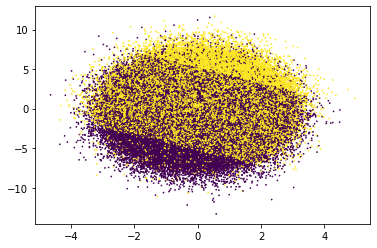

In [99]:
f_02 = train["f_02"]
f_21 = train["f_21"]
hue = train["target"]

plt.scatter(f_02, f_21, s=0.5, c = hue)

## 3. Dimensionality Reduction

In [ ]:
# Split based on the label
idx_1 = np.where(Ytr==1)
idx_0 = np.where(Ytr==0)

Xtr_1 = Xtr.iloc[idx_1]
Xtr_0 = Xtr.iloc[idx_0]

Ytr_1 = Ytr.iloc[idx_1]
Ytr_0 = Ytr.iloc[idx_0]

### 1) FLDA

In [ ]:
def FLDA_fit(A, B):
  # Covariance matrices of the two datasets
  cov1 = np.cov(A.T)
  cov2 = np.cov(B.T)
  cov_tot = (cov1+cov2)/2

  # Mean of the two datasets
  mean1 = A.mean(0)
  mean2 = B.mean(0)
  mean_diff = np.atleast_1d(mean1-mean2)

  return np.linalg.solve(cov_tot, mean_diff)

def FLDA_proj(X, w):
    Xproj = X.dot(w)
    Xproj1 = Xproj.iloc[idx_1]
    Xproj0 = Xproj.iloc[idx_0]
    return Xproj, Xproj1, Xproj0

In [ ]:
# Fit the data
flda_w = FLDA_fit(Xtr_1, Xtr_0)

# Project
Xtr_proj, Xtr_proj1, Xtr_proj0 = FLDA_proj(Xtr, flda_w)
Xte_proj = Xte.dot(flda_w)

In [ ]:
plt.hist(Xtr_proj1, color='gold', ec='black', label="label 1", alpha=0.4)
plt.hist(Xtr_proj0, color='blueviolet', ec='black', label="label 0", alpha=0.4)
plt.legend()
print("This is not linearly separable.")

### 2) PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(Xtr)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of principal components")
plt.ylabel("Expained ratio")

In [ ]:
# Try with 2 PCs
pca = PCA(n_components=2)
pca.fit(Xtr)
Xtr_pca1 = pca.transform(Xtr_1)
Xtr_pca0 = pca.transform(Xtr_0)

In [ ]:
plt.scatter(Xtr_pca1[:, 0], Xtr_pca1[:, 1], color='gold', alpha=0.35, label="label 1")
plt.scatter(Xtr_pca0[:, 0], Xtr_pca0[:, 1], color='blueviolet', alpha=0.35, label="label 0")
plt.legend()
plt.show()

print("This is not linearly separable.")

In [ ]:
# Try with 3 PCs
pca = PCA(n_components=3)
pca.fit(Xtr)
Xtr_pca1 = pca.transform(Xtr_1)
Xtr_pca0 = pca.transform(Xtr_0)

In [ ]:
# 3D Plotting
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fig3d = plt.figure(figsize = (10, 7))
ax3d = plt.axes(projection='3d')

ax3d.scatter(Xtr_pca1[:, 0], Xtr_pca1[:, 1], Xtr_pca1[:, 2], c = 'gold', label = "label 1")
ax3d.scatter(Xtr_pca0[:, 0], Xtr_pca0[:, 1], Xtr_pca0[:, 2], c = 'blueviolet', label = "label 0")

ax3d.set_title("3 COMPONENTS")
ax3d.set_xlabel("PC1")
ax3d.set_ylabel("PC2")
ax3d.set_zlabel("PC3")

plt.legend() 
plt.show()

In [ ]:
# We will use 2 PCs
pca = PCA(n_components=2)
pca.fit(Xtr)
Xtr_pca = pca.transform(Xtr)
Xte_pca = pca.transform(Xte)

### 3) Kernel Approximation - Higher Dimension

In [ ]:
from sklearn.kernel_approximation import RBFSampler

# RBF
rbf_feature = RBFSampler(gamma=1, random_state=1)
Xtr_rbf = rbf_feature.fit_transform(Xtr)
Xte_rbf = rbf_feature.fit_transform(Xte)

In [ ]:
from sklearn.kernel_approximation import Nystroem

# Nystroem
nys_feature = Nystroem(gamma=0.2, random_state=1)
Xtr_nys = nys_feature.fit_transform(Xtr)
Xte_nys = nys_feature.fit_transform(Xte)

## 3. Model Application

### 1) SVM

In [ ]:
from sklearn.svm import SVC
SVC_PCA= make_pipeline(StandardScaler(), SVC(gamma='auto'))

# Fit
SVC_PCA.fit(Xtr_pca, Ytr)

# Predict
Y_SVC = SVC_PCA.predict(Xte_pca)

# Check ROC score
roc_auc_score(Yte, Y_SVC)

### 2) SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
SGC_clf = make_pipeline(StandardScaler(), SGDClassifier(loss='log'))

# Fit
SGC_clf.fit(Xtr, Ytr)     # Using original data
# SGC_clf.fit(Xtr_rbf, Ytr)   # using kernel approximation
# SGC_clf.fit(Xtr_nys, Ytr)

# Predict
Y_SGCclf = SGC_clf.predict(Xte)
# Y_SGCclf = SGC_clf.predict(Xte_rbf)
# Y_SGCclf = SGC_clf.predict(Xte_nys)

# Check ROC score
roc_auc_score(Yte, Y_SGCclf)    # Poor!

### 3) SGD Regressor

In [ ]:
# Fit

In [ ]:
# Predict

In [ ]:
# Check ROC score